cuda
cpu counts: 128
raman on
-87.09512329101562
[0.10137781 0.15435794 0.20733808 0.31506435 0.42102461 0.63471114
 0.90137781 1.27400474]
0
1
2
3

===== Region temporal centers =====
Mode = peak   (Units: time fs, radius mm; energy fraction %)
Region  0 : r̄ =    1.082 mm ,  E =  29.72% ,  t_center =    4.88759 fs
Region  1 : r̄ =    2.054 mm ,  E =  22.13% ,  t_center =    2.93255 fs
Region  2 : r̄ =    2.649 mm ,  E =  13.07% ,  t_center =    2.93255 fs
Region  3 : r̄ =    3.145 mm ,  E =  11.66% ,  t_center =    0.97752 fs
Region  4 : r̄ =    3.581 mm ,  E =   6.34% ,  t_center =    0.97752 fs
Region  5 : r̄ =    3.962 mm ,  E =   5.82% ,  t_center =    0.97752 fs
Region  6 : r̄ =    4.345 mm ,  E =   3.56% ,  t_center =    0.97752 fs
Region  7 : r̄ =    5.299 mm ,  E =   7.70% ,  t_center =    0.97752 fs
⟨t_center⟩ (energy-weighted) = 2.82756 fs
Δt_rms (energy-weighted)     = 1.57027 fs



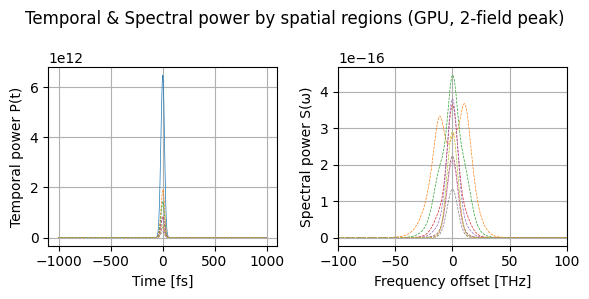


===== Diagnostics [Layer 1 — Input] =====
Energy                 : 2.7921e-01 J
Peak power             : 6474607.62 MW
Time  — FWHM / σ_t     : 40.73 fs / 17.09 fs
Freq  — FWHM / σ_v     : 14.07 THz / 10.35 THz
Space — FWHM_x / FWHM_y: 4.74 mm / 4.74 mm
Centers (t_peak / t_cm): 2.93 fs / 0.86 fs
B-integral (running)   : 0.000 (approx.)

FWHM_t(best): 20.27 fs  (GDD=-1.650e-28 s²,  TBP=0.865)
[Aperture] target=100.0% → achieved=100.0% , R≈101.82 mm,  FWHM=30.0 µm


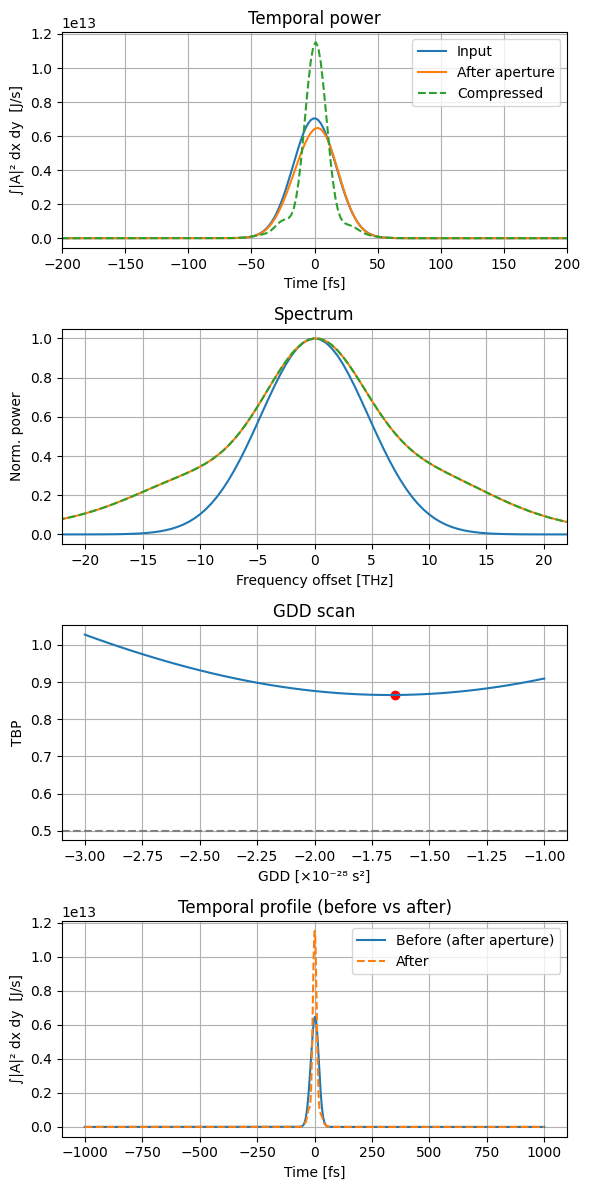


===== Region temporal centers =====
Mode = peak   (Units: time fs, radius mm; energy fraction %)
Region  0 : r̄ =    1.082 mm ,  E =  29.72% ,  t_center =    0.97752 fs
Region  1 : r̄ =    2.054 mm ,  E =  22.13% ,  t_center =    0.97752 fs
Region  2 : r̄ =    2.649 mm ,  E =  13.07% ,  t_center =    0.97752 fs
Region  3 : r̄ =    3.145 mm ,  E =  11.66% ,  t_center =    0.97752 fs
Region  4 : r̄ =    3.581 mm ,  E =   6.34% ,  t_center =    0.97752 fs
Region  5 : r̄ =    3.962 mm ,  E =   5.82% ,  t_center =    0.97752 fs
Region  6 : r̄ =    4.345 mm ,  E =   3.56% ,  t_center =    0.97752 fs
Region  7 : r̄ =    5.299 mm ,  E =   7.70% ,  t_center =    0.97752 fs
⟨t_center⟩ (energy-weighted) = 0.97752 fs
Δt_rms (energy-weighted)     = 0.00000 fs



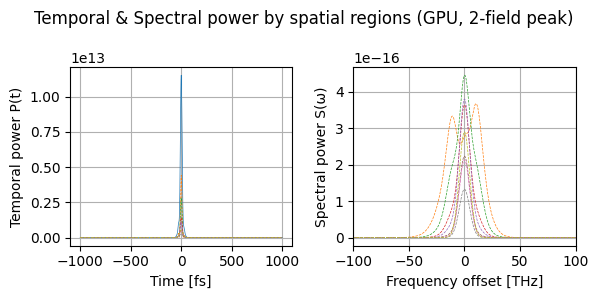

✅ All layers completed and saved


In [1]:
from IPython.display import display
import os, gc, pathlib, torch, numpy as np
import math
from datetime import datetime
import matplotlib.pyplot as plt 
from pulse_gnlse import (
    PulseGNLSESimulator,
    aperture_and_compress,
    save_A_every_step,
    visualize_simulator,
    _rms_width,
    _fwhm,
    diagnose_and_print,
    inspect_simulator,
    check_mem,    
    visualize_film,
    build_film_from_csv,
    set_film_simple,
    apply_reflective_echelon_beta01,
    build_mirror_height_map,
    visualize_mirror,
)


from visualize_time_and_freq_by_regions import visualize_time_and_freq_by_regions
from sim_blueprint import save_sim_blueprint
from strehl_after_gdd_noalloc import strehl_after_gdd_noalloc,strehl_ratio_fullfield,analyze_phase_flatness

# ---------- Utility functions -------------------------------------------------
def build_simulator(beam_profile):
    """Return an initialized PulseGNLSESimulator instance (on GPU)."""
    return PulseGNLSESimulator(beam_profile=beam_profile, **COMMON_PARAMS)

def run_one_layer(layer_idx, beam_profile):
    layer_dir = os.path.join(BASE_SAVE, f"layer_{layer_idx:02d}")
    pathlib.Path(layer_dir).mkdir(parents=True, exist_ok=True)

    # 1) Initialize
    sim = build_simulator(beam_profile)
    film, inner_radii, dL_list, names = build_film_from_csv(
        sim,
        csv_path="film/step11_layers_film_mirror_abs.csv",  # ← new filename
        nz_per_layer=1,
        dr_fwhm=0,
        aperture=3.6*w,
        col_thickness="film_after_mm"                 # ← use the fine-tuned thickness column, t_after_fine (mm)
    )    
    # Save blueprint (including COMMON_PARAMS / beam_profile meta / grids / A_in)
    save_sim_blueprint(layer_dir, COMMON_PARAMS, beam_profile, sim=sim, save_A_in=True)

    # >>> New: save input field for this layer <<<
    torch.save(sim.A_in.cpu(), os.path.join(layer_dir, "A_in.pt"))
    torch.save(
        {"x":sim.x.cpu(), "y":sim.y.cpu(), "T":sim.T.cpu()},
        os.path.join(layer_dir, "grids.pt")
    )
    
    # --- 1.1 Compute σ_v(init) (RMS angular frequency width) --------------------------
    # Compute directly on the GPU following aperture_and_compress; then immediately move to CPU
    with torch.no_grad():
        A_w_init = sim.fft_t(sim.A_in.to(sim.T.device, non_blocking=True))[1]
        torch.cuda.empty_cache()
        S_w_init = torch.sum(torch.abs(A_w_init) ** 2, dim=(0, 1)) * sim.dx * sim.dy
        sigma_w_init = _rms_width(sim.omega, S_w_init).item()
    # After computation, release temporary tensors to prevent VRAM usage
    del A_w_init, S_w_init
    torch.cuda.empty_cache()

    
    # --- 1.2 Compute FWHM_t(init) ---------------------------
    with torch.no_grad():
        P_t_init = torch.sum(
            torch.abs(sim.A_in.to(sim.T.device, non_blocking=True)) ** 2,
            dim=(0, 1)
        ) * sim.dx * sim.dy                       # 1-D temporal power
        fwhm_t_init = _fwhm(sim.T, P_t_init)      # seconds
    del P_t_init
    torch.cuda.empty_cache()


    # 2) Propagation
    sim.propagate(n_steps=COMMON_PARAMS["nz"])

    visualize_time_and_freq_by_regions(
        sim, field="output", t_unit="fs", f_unit="THz",
        center_mode="peak", report_centers=True,
        compute_dt_rms=True, return_values=True,save_path=BASE_SAVE+"/after_film",wlim=100
    )
    diagnose_and_print(sim, field="output", label=f"Layer {layer_idx} — Input")

    # >>> New: save output field for this layer <<<
    torch.save(sim.A_out.cpu(), os.path.join(layer_dir, "A_out.pt"))

    # 3) Post-processing
    # Example: first propagate to obtain sim.A_out
    # Then, before compression, let the aperture pass 85% energy with a 30 µm soft edge
    results = aperture_and_compress(
        sim,
        D_min=-3e-28, D_max=-1e-28, N_scan=41,
        plot=True, return_field=True,
        aperture_pass_fraction=1,
        aperture_fwhm=30e-6,
        return_aperture_mask=True,   # can obtain the mask
    )
 
    # 4) Save data
    torch.save(torch.tensor(sim.B_log),              os.path.join(layer_dir,"B_log.pt"))
    if "A_comp" in  results and results["A_comp"] is not None:
        torch.save(results["A_comp"].cpu(),          os.path.join(layer_dir,"A_comp.pt"))

    
    # --- 4.1 Generate a more detailed compression_summary ----------------------
    summary = (
        f"σ_v(init):  {sigma_w_init/2/np.pi/1e12:.2f} THz  →  "
        f"σ_v(comp): {results['sigma_w']/2/np.pi/1e12:.2f} THz\n"
        f"FWHM_t(init): {fwhm_t_init*1e15:.2f} fs  →  "
        f"FWHM_t(best): {results['fwhm_t']*1e15:.2f} fs\n"
        f"(GDD={results['D_opt']:.3e} s²,  TBP={results['tbp']:.3f})"
    )
    with open(os.path.join(layer_dir, "compression_summary.txt"), "w", encoding="utf-8") as f:
        f.write(summary)
    sim.A_in=None
    sim.A_out=results["A_comp"].cpu()
    torch.cuda.empty_cache()
    # 5) Fetch output field and clear VRAM
    del results
    torch.cuda.empty_cache()
    visualize_time_and_freq_by_regions(
        sim, field="output", t_unit="fs", f_unit="THz",
        center_mode="peak", report_centers=True,
        compute_dt_rms=True, return_values=True,save_path=BASE_SAVE+"/after_compress",wlim=100
    )
    A_out_cpu = sim.A_out.clone()          # CPU tensor for importing to the next layer
    del sim
    torch.cuda.empty_cache()
    return A_out_cpu
    
s=1.31071
w=4e-3

# ---------- Common parameters (same as the original script; can be centralized in a config file) ----------
COMMON_PARAMS = dict(
    pulse_energy    = 300e-3,
    t_fwhm          = 40e-15,
    nt              = 2**10,
    t_window_factor = 50,
    lambda0         = 800e-9,
    dispersion      = {1: 1.468/2.99792458e8, 2: 36e-27, 3: 2.75e-41, 4: -2.79e-56},
    n0              = 1.4530,
    n2              = np.array([[532e-9, 2.24e-20],[1064e-9, 2.14e-20]]),
    L               = 0.10137781e-3,
    nz              = 4 ,
    compression_steps = 1000,
    Nx = 2**9, Ny = 2**9,
    x_window = 18*w*2,  y_window = 18*w*2,
    retarded_frame  = True,
    alpha           = 2.5e-4,
    raman           = {'f_R':0.18,'tau1':12.2e-15,'tau2':32e-15},
    noise           = None,
    device          = str(torch.device("cuda" if torch.cuda.is_available() else "cpu")),
)

INIT_BEAM = {           # First layer uses a super-Gaussian profile
    "shape":"supergauss",
    "waist":w,
    "order":2,
}

BASE_SAVE = "/rds/general/ephemeral/user/fy624/ephemeral/github"
A_seed = None
N_LAYERS = 1


for layer in range(1, N_LAYERS+1):
        if layer == 1:
            beam_prof = INIT_BEAM
        else:
            beam_prof = {"shape":"import", "field":A_seed, "renorm":False}
        A_seed = run_one_layer(layer, beam_prof)

print("✅ All layers completed and saved")
